# Importing Libraries

In [2]:
#!pip install keras
#!pip install tensorflow
#!pip install spacy
import numpy as np
import pandas as pd
import csv
import keras
import sklearn
import random
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
import io
import string
#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS
#from spacy.lang.en import English
#import en_core_web_sm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline


Using TensorFlow backend.


# Data Exploration

In [3]:

print ("Reading text data for classification and building representations...")
df = pd.read_excel ("C:\\Users\\v-savrav\\Text\\data\\datasetv1.xlsx")

Reading text data for classification and building representations...


In [77]:
df.columns

Index(['index', 'PrimaryTopic', 'secondarytopic', 'Description', 'id'], dtype='object')

# Input: 'Description'
# Output :'PrimaryTopic'

In [78]:
num_classes = len( set(df['PrimaryTopic']) )
num_classes

1

In [79]:
df['PrimaryTopic'].value_counts()

Invoice Management    39846
Name: PrimaryTopic, dtype: int64

In [80]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#is based on The Porter Stemming Algorithm
stopwords = stopwords.words("english")
snowball_stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_filtered = df[df['PrimaryTopic']== 'Invoice Management']
df=df_filtered.dropna()
df['Description']=df['Description'].astype(str)
df=df.reset_index()
# tokenization 
tokenized_doc = df['Description'].apply(lambda x: x.split())

# remove stop-words 

tokenized_doc = tokenized_doc.apply(lambda x: [wordnet_lemmatizer.lemmatize(item) for item in x if item not in stopwords])
#tokenized_doc = tokenized_doc.apply(lambda x: [snowball_stemmer.stem(item) for item in x ])
# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 


In [82]:
df['secondarytopic'].value_counts()

Invoice Payment Status                            19985
Email Invoice and Refund Submission               11642
Invoice Change Request                             2447
Statement of Account Request                       1291
Approver Activities Change Approver                1084
User Education on Tool and Process                  763
Paper Invoice not received and Scanning Errors      409
Einvoice- invoice copy requirement                  375
GPRP Request                                        325
Invoice Tax Issues                                  279
Return to Vendor RTV                                278
AP24 - Debit balances                               199
SPR Request                                         191
VAT/TAX payments                                    164
Non PO Supplier List Maintenance                    107
AP24 - Refunds                                       67
AP24 - Advance payments                              64
AP24-Failed payments                            

In [10]:
import string

def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

df['Description'] = df['Description'].apply(remove_punctuation)

# Factorising the Primary Topic to ID

In [11]:
df['id'] = df['secondarytopic'].factorize()[0]
category_id_df = df[['secondarytopic', 'id']].drop_duplicates().sort_values('id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['id', 'secondarytopic']].values)
df.head()

,index,PrimaryTopic,secondarytopic,Description,id
0,4,Invoice Management,Einvoice- invoice copy requirement,Hi Prohelp team I request submit payment follo...,0
1,7,Invoice Management,Invoice Payment Status,Hola Se puede usar la tarjeta de MS para pagos...,1
2,8,Invoice Management,Invoice Payment Status,Talebiniz bize ulasti Degerli Müsterimiz Taleb...,1
3,9,Invoice Management,Statement of Account Request,QVR 1086 Austria,2
4,15,Invoice Management,Invoice Payment Status,Hi Team Good day We resubmitted invoice updati...,1


In [83]:
len(df)

39846

# Removing NULL records

In [55]:
from io import StringIO

df1 = pd.DataFrame({'Description':df['Description'],'id':df['id']})
#df1 = df[[pd.notnull(df['secondarytopic'])]

# Imbalanced Classes
We see that the number of complaints per product is imbalanced. Consumers’ complaints are more biased towards 
Invoice Management, Payee Account Management and Travel and Expenses Management.


However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy
for the minority classes. Therefore, we will leave it as it is.

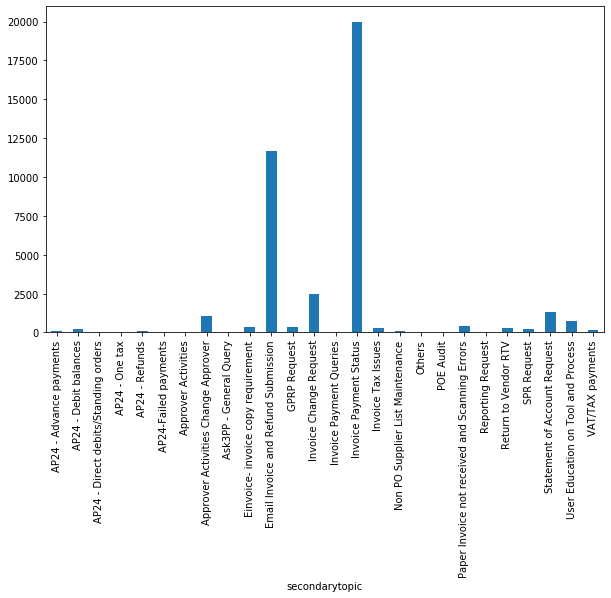

In [84]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
df.groupby('secondarytopic').Description.count().plot.bar(ylim=0)
plt.show()

In [16]:
X=df['Description']
labels=labels = df.id

# Text Representation

In [85]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
count_vect=CountVectorizer(max_df=0.95, min_df=2,
                                #max_features=n_features,
                                stop_words='english')

In [ ]:
X_counts = count_vect.fit_transform(X)

In [ ]:
tfidf_transformer = TfidfTransformer()
features = tfidf_transformer.fit_transform(X_counts)

In [ ]:
features.shape

In [38]:
from sklearn.feature_extraction.text import HashingVectorizer

vector = HashingVectorizer(decode_error = 'ignore',
                          n_features = 2**21,
                          preprocessor = None,
                           encoding='utf-8')

In [39]:
vector

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
                  decode_error='ignore', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=2097152, ngram_range=(1, 1), norm='l2',
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

In [88]:
X = vector.fit_transform(df1)
print(X.shape)

(2, 2097152)


Now, each of 3827 consumer complaint narratives is represented by 913 features, representing the tf-idf score for different unigrams and bigrams.

# Model Training -Bayesian Classification

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(features,labels, random_state = 0)
clf = MultinomialNB().fit(X_train, y_train)

In [60]:
def tweetGenerator(df):
    """
    This function takes a tweet from the data frame
    and returns the text of the tweet as well as the sentiment label
    """
    for row in df.itertuples():
        label = row[1]
        tweet = row[2]
        yield tweet, label

In [ ]:
# Group values for Series and add 'cnt' column with count
df1['cnt'] = df1.groupby(['Series'])['id'].transform('count')
# Drop indexes for count value == 1, and dropping 'cnt' column
df.drop(df[df.cnt==1].index)[['Country','Series']]

In [65]:
vc=df1['id'].value_counts()
u  = [i not in set(vc[vc==1].index) for i in df1['id']]
df1 = df1[u]

In [69]:
df1

,Description,id
0,Hi Prohelp team I request submit payment follo...,0
1,Hola Se puede usar la tarjeta de MS para pagos...,1
2,Talebiniz bize ulasti Degerli Müsterimiz Taleb...,1
3,QVR 1086 Austria,2
4,Hi Team Good day We resubmitted invoice updati...,1
5,Accounts Payable Reconciliation 2297780 Prim...,2
6,Hi I’m trying approve invoice system return er...,1
7,Dear Sirs received payment Microsoft Global Fi...,1
8,From AMERICAN EXPRESS INTL SA Adobe Acrobat Re...,1
9,From AMERICAN EXPRESS INTL SA Adobe Acrobat Re...,1


In [61]:
from sklearn.naive_bayes import MultinomialNB
MNBclassifier = MultinomialNB(alpha = 0.01)
tweet_gen = tweetGenerator(df1)

In [ ]:
#!pip install pyprind
import pyprind
batchSize = 5000
totalTweets = len(df1)
#totalTweets = 150001
iterations = totalTweets/batchSize
progressBar = pyprind.ProgBar(iterations)

classes = np.array([0, 22])

In [ ]:
for i in range(iterations):
    X_train, y_train = getBatch(tweet_gen, size=batchSize)
    X_train = vector.transform(X_train)
    MNBclassifier.partial_fit(X_train, y_train, classes=classes)
    BernoulliNBclassifier.partial_fit(X_train, y_train, classes=classes)
    SGDclassifier.partial_fit(X_train, y_train, classes=classes)
    PassiveAggressiveclassifier.partial_fit(X_train, y_train, classes=classes)
    progressBar.update()

In [46]:
from sklearn.externals import joblib
filename = 'finalized_model.sav'
joblib.dump(clf, filename)

C:\Users\v-savrav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['finalized_model.sav']

In [90]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(max_iter=5, tol=1e-3),
    'Perceptron': Perceptron(tol=1e-3),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(tol=1e-3),
}

# Comparing with other Classifcation Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0),
    LinearSVC(),
    SVC(kernel='rbf', random_state=0, gamma=100, C=10),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

C:\Users\v-savrav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\v-savrav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\v-savrav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [ ]:
cv_df.groupby('model_name').accuracy.mean()


# Confusion Matrix
   The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications,and it might be interesting to see what those are caused by:

In [ ]:
model = LinearSVC()
model1= RandomForestClassifier()
model2=SVC()

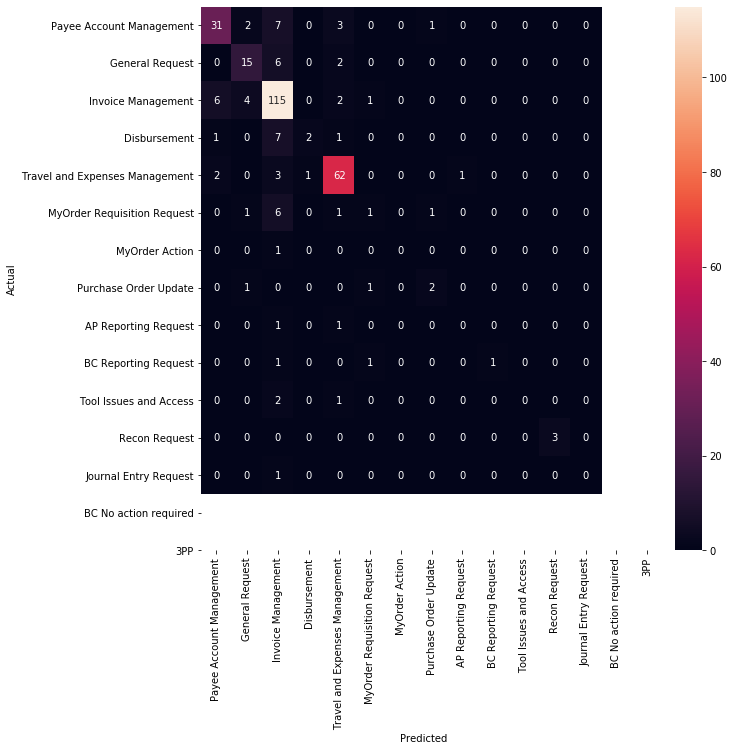

In [71]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.PrimaryTopic.values, yticklabels=category_id_df.PrimaryTopic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [99]:
115+62+15+31+10

233

In [110]:
233/302

0.7715231788079471

In [95]:
df_filtered = df[df['PrimaryTopic']!='3PP']
df_filtered = df_filtered[df['PrimaryTopic']!='BC No action required']
#df['PrimaryTopic']!='3PP'#, 'BC No action required']#df.drop(['3PP', 'BC No action required'],axis=0)

C:\Users\v-savrav\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [96]:
df_filtered['PrimaryTopic'].value_counts()
df_filtered['PrimaryTopic']

Invoice Management                372
Travel and Expenses Management    179
Payee Account Management          166
General Request                    80
Disbursement                       34
MyOrder Requisition Request        32
Purchase Order Update              14
Recon Request                      10
BC Reporting Request                9
AP Reporting Request                5
MyOrder Action                      4
Journal Entry Request               3
Tool Issues and Access              3
Name: PrimaryTopic, dtype: int64

In [80]:
df['PrimaryTopic'].value_counts()

Invoice Management                372
Travel and Expenses Management    179
Payee Account Management          166
General Request                    80
Disbursement                       34
MyOrder Requisition Request        32
Purchase Order Update              14
Recon Request                      10
BC Reporting Request                9
AP Reporting Request                5
MyOrder Action                      4
Journal Entry Request               3
Tool Issues and Access              3
3PP                                 1
BC No action required               1
Name: PrimaryTopic, dtype: int64

# Report

In [97]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df_filtered['PrimaryTopic'].unique()))

                                precision    recall  f1-score   support

      Payee Account Management       0.78      0.70      0.74        44
               General Request       0.65      0.65      0.65        23
            Invoice Management       0.77      0.90      0.83       128
                  Disbursement       0.67      0.18      0.29        11
Travel and Expenses Management       0.85      0.90      0.87        69
   MyOrder Requisition Request       0.25      0.10      0.14        10
                MyOrder Action       0.00      0.00      0.00         1
         Purchase Order Update       0.50      0.50      0.50         4
          AP Reporting Request       0.00      0.00      0.00         2
          BC Reporting Request       1.00      0.33      0.50         3
        Tool Issues and Access       0.00      0.00      0.00         3
                 Recon Request       1.00      1.00      1.00         3
         Journal Entry Request       0.00      0.00      0.00  

C:\Users\v-savrav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
category_id_df = df[['PrimaryTopic', 'id']].drop_duplicates().sort_values('id')

In [102]:
from IPython.display import display
for predicted in category_id_df.id:
    for actual in category_id_df.id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['PrimaryTopic', 'Description']])
            print('')

'Invoice Management' predicted as 'Payee Account Management' : 6 examples.


,PrimaryTopic,Description
205,Invoice Management,The surprising benefits of flexible workspace ...
327,Invoice Management,"Hello ProHelp, Please see the attached LEGAL_..."
781,Invoice Management,"Hello Prohelp Desk, Can you please provide a..."
297,Invoice Management,Thank you – I think you may have got the Austr...
957,Invoice Management,"Hi Ap, Could you please process enclosed Eif..."
288,Invoice Management,"Hi APIE Team, We had submitted a request to a..."



'Disbursement' predicted as 'Payee Account Management' : 1 examples.


,PrimaryTopic,Description
300,Disbursement,"Hello, I am getting the error below when I tr..."



'Travel and Expenses Management' predicted as 'Payee Account Management' : 2 examples.


,PrimaryTopic,Description
70,Travel and Expenses Management,"Dear ?, Please considerthis as a reference n..."
86,Travel and Expenses Management,"Dear ?, Please considerthis as a reference n..."


IndexError: index 13 is out of bounds for axis 0 with size 13

# Bigrams,Unigrams -term counts in document classification

In [112]:
category_to_id

{'Payee Account Management': 0,
 'General Request': 1,
 'Invoice Management': 2,
 'Disbursement': 3,
 'Travel and Expenses Management': 4,
 'MyOrder Requisition Request': 5,
 'MyOrder Action': 6,
 'Purchase Order Update': 7,
 'AP Reporting Request': 8,
 'BC Reporting Request': 9,
 'Tool Issues and Access': 10,
 'Recon Request': 11,
 'Journal Entry Request': 12,
 'BC No action required': 13,
 '3PP': 14}

In [111]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '3PP':
  . Most correlated unigrams:
. diretamente
. dies
  . Most correlated bigrams:
. diretamente com
. überwachtes postfach
# 'AP Reporting Request':
  . Most correlated unigrams:
. diretamente
. dies
  . Most correlated bigrams:
. diretamente com
. überwachtes postfach
# 'BC No action required':
  . Most correlated unigrams:
. diretamente
. dies
  . Most correlated bigrams:
. diretamente com
. überwachtes postfach
# 'BC Reporting Request':
  . Most correlated unigrams:
. diretamente
. dies
  . Most correlated bigrams:
. diretamente com
. überwachtes postfach
# 'Disbursement':
  . Most correlated unigrams:
. diretamente
. dies
  . Most correlated bigrams:
. diretamente com
. überwachtes postfach
# 'General Request':
  . Most correlated unigrams:
. diretamente
. dies
  . Most correlated bigrams:
. diretamente com
. überwachtes postfach
# 'Invoice Management':
  . Most correlated unigrams:
. diretamente
. dies
  . Most correlated bigrams:
. diretamente com
. überwachtes postfach
# 